# Networking for Big Data - Project
- Jonas Barth 2050678
- Susanna Bravi 1916681
- Eric Rubia Aguilera 2049558

In [2]:
# Libraries
import pyshark
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy
import sys
import shutil
import os
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm


# Part A
#### 1. Extract general info from your trace using capinfos

In [ ]:
!capinfos -A _00000_20190410070000.pcap

#### 2. Time Evaluation between Sequential and Parallel reading

We evaluate the time taken to process `.pcap` file sequentially and parallely as a function of the number of packets in the `.pcap` file. This allows us to show how the processing time scales with the number of packets. We initially used the `pyshark` library, however since it proved to be too slow to allow for a fast turnaround, we decided to use the `scapy` library instead which offers a similar functionality to `pyshark` but with better speed. Each processing algorithm is timed once, using Python's `timeit` package.
   
The [read.py](read.py) script lets you time either a sequential or parallel algorithm for a single `.pcap` file. The results are stored in a `.feather` file.,

We run the processing for the following number of packets:,

* 10
* 100
* 1000
* 10000
* 100000
* 1000000

##### Sequential Processing,
The sequential processing, opens the `.pcap` file, reads the packets one by one into domain objects, creates a dataframe, and closes the file.,

##### Parallel Processing,
The parallel processing algorithm first divides the given `.pcap` file into $n$ smaller `.pcap` files of $p$ packets each. Then, a maximum of $m$ processes are started in parallel, each of which processes a single `.pcap` file sequentially. The number of parallel processes is capped at the parameter $m$ as not to overwhelm the available computing resources.,

#### Results,
The sequential and parallel processing algorithms were run once for each `.pcap` file. The line plot below shows the processing time in seconds for the number of packets in the `.pcap` files. For files with a number of packets $\le 10000$, the parallel and sequential reading takes more or less the same amount of time. For the largest file of $1000000$ packets, the parallel processing is much faster than the sequential processing.,

With parallel processing, there is some overhead in splitting the original file and starting the processes, hence we can expect that the pay off of parallel processing to be insignificant for a small number of packets.

First, we combine all the different measurement dataframes into a single one

In [ ]:
timing_df = reduce(lambda a, b: pd.concat((a, b), axis=0, ignore_index=True), map(lambda df_path: pd.read_feather(df_path), glob.glob("data/timing_results/*.feather")))
parallel_times = timing_df[timing_df.read_type == 'parallel']
sequential_times = timing_df[timing_df.read_type == 'sequential']

Then we plot.

In [ ]:
n = parallel_times.shape[0]
plt.plot(parallel_times.n_packets, parallel_times.time_s, label="Parallel")
plt.plot(sequential_times.n_packets, sequential_times.time_s, label="Sequential")
plt.xticks([10**i for i in range(1, n + 1)], [f"$10^{i}$" for i in range(1, n + 1)])
plt.legend()
plt.xscale("log")
plt.xlabel("Number of Packets")
plt.ylabel("Seconds")
plt.title("Sequential vs Parallel Processing of pcap Files")
plt.show()

#### 3. Extract the IP which generates the highest amount as sender traffic, evaluate the bit rate (0.1 sec) for the 6 IP addresses mostly used as endpoint


In [3]:
dataFrame = pd.read_feather("packets.feather")
len(dataFrame)

832768

In [ ]:
#dataFrame.head()
source = dataFrame.groupby(["IP_SRC"])
len(source) #we have 4548 different sources
# what is the source that sends more pckts?

In [ ]:
data_couple = dataFrame.groupby(["IP_SRC"])[['length']].agg('sum')
print(data_couple.sort_values(by=['length'], ascending=False).head(10))

In [ ]:
max = data_couple.max()
print(data_couple.loc[data_couple['length'] == int(max.iloc[0])])
#so maybe the ip source that generates more traffic is 150.57.136.251

In [ ]:
onlyTheSource = dataFrame[dataFrame["IP_SRC"] == "150.57.136.251"]

data_destination = onlyTheSource.groupby(["IP_DST"])[['length']].agg('sum').sort_values(by=['length'], ascending=False).head(6)

data_6IPs = onlyTheSource.groupby(["IP_DST"])
print(data_destination)

rowlength = int(data_destination.shape[0]/2)


In [ ]:
fig = px.histogram(dataFrame["length"], x='length',
                   nbins=15, 
                   title='Histogram of Packet Length',
                   labels={'length':'Packet Length (Byte)'},
                   opacity=0.8,
                   log_y=False,
                   color_discrete_sequence=['#2a9d8f'],
                   text_auto=True,
                   template='plotly_white',
                   width=800, 
                   height=400)
fig.update_layout(
    yaxis_title_text='Frequency',
    bargap=0.2, # gap between bars of adjacent location coordinates
    #margin=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="gray"
)
fig.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)
fig.show(renderer='notebook')

In [ ]:
def bitRate(data, step_sec = 0.1):
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    #print("Start: ",start)
    #print("Finish: ",finish)
    
    
    data["time"] -= data.iloc[0]["time"]
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    
    #print("Start: ",start)
    #print("Finish: ",finish)
    
    step = finish/ step_sec
    finish = start + step_sec
    value = []
    #print(step)
    for i in range(int(step)):
    
        #From Byte to bit - selection of the time interval between the start and the end of a single time slot
        val = np.sum(data[(data["time"]>=start) & (data["time"]<finish)]["length"]*8)
        if not np.isnan(val):
            value.append(val/step_sec)
        start = finish 
        finish = start + step_sec
        
    return value


In [ ]:
fig, axs = plt.subplots(figsize=(20,12), 
                        nrows=2, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 
#fig.tight_layout()
targets = zip(data_destination.index, axs.flatten())
for i, (key, ax) in enumerate(targets):
    print(key)
    #ax.plot(data_couple.get_group(key)["length"])
    ax.plot(bitRate(data_6IPs.get_group(key)),marker = "o")
    ax.set_title(key)
    ax.set_xlabel("T (sec)")
    ax.set_ylabel("bit/sec")
    #ax.set_yscale('log')
fig.suptitle('TOP 6 IP Dst for 150.57.136.251', fontsize=16)
#plt.savefig("TOP 6 IP Dst for MyIP")
plt.show()

#If now the step in bit rate is 0.1 second, the label of the x axes remains in seconds?

#### 4. Top 5 Destination IP (received bytes) and Top 5 Source IP (sent bytes)


In [ ]:
data_top5dest = dataFrame.groupby(["IP_DST"])[['length']].agg('sum').sort_values(by=['length'], ascending=False).head(5)
data_top5dest

In [ ]:
bar_dest = px.bar(data_top5dest, y=data_top5dest.index[:], x = data_top5dest['length'][:]/1e3,
                    title='Top 5 destinations',
                    opacity=0.8,
                    color_discrete_sequence=['#e5b769'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)
bar_dest.update_layout(
    yaxis_title_text ='Destinations',
    xaxis_title_text ='Received Bytes')# gap between bars of adjacent location coordinates
bar_dest.update_yaxes(tickfont_family="Arial Black")
bar_dest.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)



In [ ]:
data_top5source = data_couple.sort_values(by=['length'], ascending=False).head(5)

In [ ]:
bar_source = px.bar(data_top5source, y=data_top5source.index[:], x = data_top5source['length'][:]/1e3,
                    title='Top 5 sources',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)
bar_source.update_layout(
    yaxis_title_text ='Sources',
    xaxis_title_text ='Bytes Sent')
bar_source.update_yaxes(tickfont_family="Arial Black")
bar_source.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

#### 5. Evaluate bitRate considering all the trace with 3 different sampling rate

In [ ]:
bit_plot = px.line(dataFrame,
              x=[ i*0.1 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))))+1)],
              y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))),
              template='plotly_white',
              title='Total bit rate',
              markers=True)
bit_plot['data'][0]['showlegend'] = True
bit_plot['data'][0]['name'] = '0.1 sec'
bit_plot.add_scatter(x=[ i*0.4 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.4))))+1)], 
                y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.4))),name="0.4 sec")
bit_plot.add_scatter(x=[ i*0.8 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.8))))+1)], 
                y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.8))),name="0.8 sec")
bit_plot.update_layout(
    yaxis_title_text ='Mbps',
    xaxis_title_text ='Time(s)')


#### 6. GeoLocal Referenciation of the 5 sessions with the highest amount of traffic generated

In [ ]:
from ip2geotools.databases.noncommercial import DbIpCity
import folium

In [ ]:
def geo_infos(ip_src_list, ip_dst_list):

  src_geo_info = []
  dst_geo_info = []
  i = 0

  for j in range(len(ip_src_list)):
    try:
      src_response = DbIpCity.get(ip_src_list[j], api_key='free')
      dst_response = DbIpCity.get(ip_dst_list[j], api_key='free')
    except:
      continue
    if src_response.latitude == None or dst_response.latitude == None: 
      continue
    i +=1
    src_geo_info.append([src_response.latitude, src_response.longitude, src_response.region])
    dst_geo_info.append([dst_response.latitude, dst_response.longitude, dst_response.region])
    if i == 10: break

  return src_geo_info, dst_geo_info


In [ ]:
data_couple = copy.deepcopy(dataFrame)
#Change your local IP with the one used to navigate on the Web
#data_couple["IP_SRC"]= data_couple["IP_SRC"].replace({'192.168.43.28':'46.37.14.27'})
#data_couple["IP_DST"] = data_couple["IP_DST"].replace({'192.168.43.28':'46.37.14.27'})
dataUnssrcdst = list(zip(data_couple.IP_SRC, data_couple.IP_DST))

mostcommon_srcdst = Counter(dataUnssrcdst).most_common(5)
mostcommon_srcdst

In [ ]:
list_src = []
list_dst = []

for i in range(len(mostcommon_srcdst)):
    list_src.append(mostcommon_srcdst[i][0][0]) #src pos 0
    list_dst.append(mostcommon_srcdst[i][0][1]) #dst pos 1

#src_geo, dst_geo = geo_infos(list(top_10_flows['ip_src']), list(top_10_flows['ip_dst']))

#Sigle Couple
#src_geo, dst_geo = geo_infos(['185.86.84.30'],['46.37.14.27'])
#5 Couples
src_geo, dst_geo = geo_infos(list_src, list_dst)

src_geo = pd.DataFrame(src_geo, columns=['latitude', 'longitude', 'region'])
dst_geo = pd.DataFrame(dst_geo, columns=['latitude', 'longitude', 'region'])

print("Data:  \n")
print(src_geo)
print()
print(dst_geo)
print("\n")

flow_map = folium.Map([0, 0], zoom_start=2, tiles='Stamen Terrain')

for i in range(len(src_geo)):
  folium.Marker([src_geo.loc[i][0], src_geo.loc[i][1]], popup='<i>Mt. Hood Meadows</i>', 
                icon=folium.Icon(color='green')).add_to(flow_map)
  folium.Marker([dst_geo.loc[i][0], dst_geo.loc[i][1]], popup='<i>Mt. Hood Meadows</i>',  
                icon=folium.Icon(color='red')).add_to(flow_map)
  folium.PolyLine([(src_geo.loc[i][0], src_geo.loc[i][1]), (dst_geo.loc[i][0], dst_geo.loc[i][1])], 
                  color="blue", weight=1.5, opacity=1).add_to(flow_map)

#flow_map.save(folder_image +"Map_top_5_flows.html")
#display(flow_map)

#### 7. 10 Protocol mostly used

In [ ]:
grouped_flows = dataFrame.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
print(grouped_flows)

In [ ]:
grouped_flows.Protocol.value_counts().index #we have only 9 protocols??

In [ ]:
grouped_flows["Protocol"] = grouped_flows["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP",50:"ESP",4:"IPv4",47:"GRE",89:"OSPFIGP",97:"ETHERIP",103:"PIM"}) 
#like this util we do not found the name of the other protocols
#found them in https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

In [ ]:
bar_protocol = px.bar(grouped_flows["Protocol"], y=grouped_flows.Protocol.value_counts().index, x = grouped_flows.Protocol.value_counts().values,
                    title='Top 9 Protocols used',
                    opacity=0.8,
                    color_discrete_sequence=['#2a9d8f'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)

bar_protocol.update_layout(
    yaxis_title_text ='Prtocols',
    xaxis_title_text ='Count')
bar_protocol.update_yaxes(tickfont_family="Arial Black")
bar_protocol.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

### 8. Port Scanner evaluation (10 Ports mostly used)

In [ ]:
def port_scan (x, dic):
    ''' scan through the ports and update the counter at each import file. 
    save only the info for the well-known ports '''
    for port in x:
        if pd.isnull(port) == False:
            #Well-Known Ports
            if int(port) < 1024:
                if port not in dic.keys():
                    dic[port] = 1
                else:
                    dic[port] += 1
    return(dic)

In [ ]:
#Scanning port analysing pandasDataframe, both for source and destination ports
source_ports = {}
source_ports = port_scan(dataFrame["src_port"], source_ports)
dest_ports = {}
dest_ports = port_scan(dataFrame["dst_port"], dest_ports)

pd.DataFrame.from_dict(source_ports, orient = 'index').to_json('./source_ports.json')
pd.DataFrame.from_dict(dest_ports, orient = 'index').to_json('./dest_ports.json')

sports = pd.read_json('./source_ports.json')
dports = pd.read_json('./dest_ports.json')

sports = sports.reset_index()
dports = dports.reset_index()
sports = sports.rename(columns = {'index':'port', 0:'count'})
dports = dports.rename(columns = {'index':'port', 0:'count'})

sports = sports.sort_values(by = 'count', ascending = False)
dports = dports.sort_values(by = 'count', ascending = False)

In [ ]:
aux=dataFrame[dataFrame['dst_port']==-1]
aux=aux[aux['Protocol']==17]
#aux

# We observe that these pkts have a defult -1 for source and destination number since they seem to be related to
#control rather than to messages, but there are some UDP pkts... weirddddddo

In [ ]:
#dports['port']=dports['port'].astype('string')
dports_10 = dports.sort_values(by=['count'], ascending=False).head(10)
dports_10["port"] = dports_10["port"].replace({443:"443 - HTTPS",80:"80 - HTTP",-1:"-1 - ICMP",53:"53 - DNS",873:"873 - rsync",993:"993 - IMAP4",22:"22 -SSH",161:"161 - SNMP ",25:"25 - SMTP",123:"123 - NTP"}) 
#sports['port']=sports['port'].astype('string')
sports_10 = sports.sort_values(by=['count'], ascending=False).head(10)
sports_10["port"] = sports_10["port"].replace({443:"443 - HTTPS",80:"80 - HTTP",-1:"-1 - ICMP",53:"53 - DNS",873:"873 - rsync",993:"993 - IMAP4",22:"22 -SSH",161:"161 - SNMP ",25:"25 - SMTP",123:"123 - NTP"}) 

In [ ]:
port_plot = px.bar(dports_10,x=dports_10['port'],y=dports_10['count'],text_auto=True,
                    title='Top 10 Destination ports used',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    template='plotly_white',
                    width=800, 
                    height=400)
'''
port_plot.update_layout(
    yaxis_title_text ='Ports',
    xaxis_title_text ='Count')
port_plot.update_xaxes(tickfont_family="Arial Black")
port_plot.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)'''

In [ ]:
sport_plot = px.bar(sports_10,x=sports_10['port'],y=sports_10['count'],text_auto=True,
                    title='Top 10 Source ports used',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    template='plotly_white',
                    width=800, 
                    height=400)
'''
sport_plot.update_layout(
    yaxis_title_text ='Ports',
    xaxis_title_text ='Count')
sport_plot.update_xaxes(tickfont_family="Arial Black")
sport_plot.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)'''

In [ ]:
#maybe we prefer them together?
fig = make_subplots(rows=1, cols=2,subplot_titles=("Destination Ports", "Source Ports"),shared_yaxes=True)
fig.add_trace(port_plot['data'][0], row=1, col=1)
fig.add_trace(sport_plot['data'][0], row=1, col=2)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="10 most used ports",
    xaxis_title_text ='Ports',
    yaxis_title_text ='Count')
fig.update_layout(template='plotly_white')
fig.update_xaxes(tickfont_family="Arial Black")
fig.update_xaxes(title_text="ports", row=1, col=2)
fig.update_yaxes(title_text="count", row=1, col=2)
fig.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

### 9. InterArrival Time boxplot between TCP and UDP Sessions

In [ ]:
import copy
from collections import Counter

def InterArrivalTime(data):
    val = np.array(data["time"])
    #Calculate the n-th discrete difference along the given axis
    return np.diff(val)

data_protocol = copy.deepcopy(dataFrame[dataFrame["Protocol"].isin([6,17])])
data_protocol["Protocol"] = data_protocol["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP"})

print(Counter(data_protocol["Protocol"]))

In [ ]:
box_len = px.box(data_protocol, y="length", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#Seems like we have small pkts
#From the histogram at the beginning of the document we can see that almost all the pkts are < 2000 byte
#Let's try to do for only pkts of this size

In [ ]:
data_protocol_2000 = data_protocol[data_protocol["length"]<= 2860]
box_len_2000 = px.box(data_protocol_2000, y="length", x='Protocol', color='Protocol',template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
# The TCP box is quite big so the interquantile range is large... so we have data that is quite variable
# The UDP's box is smaller that the TCP one so here the variance is smaller and also the size of the pckts is smaller that the TCP. UDP also does not have pckts pf size bigger that 1500 byte while TCP has
# a median equal to 1299 so the 50% of the pckts are bigger taht 1300 bytes.

In [ ]:
np.quantile(np.array(data_protocol['length']),q=0.9)

In [ ]:
fig = make_subplots(rows=1, cols=4,subplot_titles=("Original data UDP","Original data TCP", "Pckts whit length < 2000 bytes UDP","Pckts whit length < 2000 bytes TCP"))
fig.add_trace(box_len['data'][0], row=1, col=1)
fig.add_trace(box_len['data'][1], row=1, col=2)
fig.add_trace(box_len_2000['data'][0], row=1, col=3)
fig.add_trace(box_len_2000['data'][1], row=1, col=4)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="Packets length")
fig.update_layout(template='plotly_white',showlegend=False)

In [ ]:
soloUDP = data_protocol[data_protocol["Protocol"]=='UDP']
np.max(np.array(soloUDP['length']))
#no UDP pckts bigger than 1500 bytes.. 
#maybe we should know why from the theory? 

In [ ]:
#Inter arrival time
tcp_data = data_protocol_2000[data_protocol_2000["Protocol"]=="TCP"]
udp_data = data_protocol_2000[data_protocol_2000["Protocol"]=="UDP"]

inteArr_TCP= []
for elem in tcp_data.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']):
    #groupby tuple (key,dataframe)
    inteArr_TCP += InterArrivalTime(elem[1]).tolist()

inteArr_UDP = []
for elem in udp_data.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']):
    inteArr_UDP += InterArrivalTime(elem[1]).tolist()


val_ = inteArr_TCP + inteArr_UDP

label_TCP = [ "TCP" for i in range(len(inteArr_TCP))]
label_UDP =[ "UDP" for i in range(len(inteArr_UDP))]

lab_ = label_TCP + label_UDP

d = {'Protocol': lab_, 'IntArrTime': val_}
df = pd.DataFrame(data=d)

In [ ]:
print("Mean InterArrivalTime TCP Session: %.4f"% np.mean(np.array(inteArr_TCP)))
print("Mean InterArrivalTime UDP Session: %.4f"% np.mean(np.array(inteArr_UDP)))
#the TCP interarrival time is smaller than the UDP
#median?
print("Median InterArrivalTime TCP Session: %.5f"% np.median(np.array(inteArr_TCP)))
print("Median InterArrivalTime UDP Session: %.5f"% np.median(np.array(inteArr_UDP)))
# 3rd quartile
print("3rd quartile InterArrivalTime TCP Session: %.5f"% np.quantile(np.array(inteArr_TCP),q=0.75))
print("3rd quartile InterArrivalTime UDP Session: %.5f"% np.quantile(np.array(inteArr_UDP),q=0.75))
#After this make sense to plot it for values less that 0.00004 (median of TCP) seconds and 0.0009 (median of UDP)

In [41]:
tcp_median = round(np.median(np.array(inteArr_TCP)),7)
udp_median = round(np.median(np.array(inteArr_UDP)),7)

In [ ]:
df1 = df[df["IntArrTime"] <  udp_median]
fig1 = px.box(df1, y="IntArrTime", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
fig1.show()

In [38]:
df2 = df[df["IntArrTime"] < tcp_median]
fig2 = px.box(df2, y="IntArrTime", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=4,subplot_titles=(f"TCP < {tcp_median} s", f"UDP < {udp_median} s",f"TCP < {tcp_median}", f"UDP < {udp_median}"))
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig1['data'][1], row=1, col=2)
fig.add_trace(fig2['data'][0], row=1, col=3)
fig.add_trace(fig2['data'][1], row=1, col=4)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="Interarrival time",
    yaxis_title_text='Time (s)')
fig.update_layout(template='plotly_white',showlegend=False)

### 10. Develope your own analysis (e.g. Topology of the network using networkx) 

In [43]:
import networkx as nx
import random
from networkx.algorithms import approximation as apx
random.seed(26111998) # COMPLEANNO DI MAVI <3

In [44]:
Dest_IPs,Source_IPs=list(dataFrame['IP_DST']),list(dataFrame['IP_SRC'])
len(np.unique(Dest_IPs+Source_IPs))

18413

In [45]:
data_udp=dataFrame[dataFrame['Protocol']==17]
data_tcp=dataFrame[dataFrame['Protocol']==6]
data_ICMP=dataFrame[dataFrame['Protocol']==1]
data_transport=dataFrame[(dataFrame['Protocol']==17) | (dataFrame['Protocol']==6)]


In [46]:
Dest_IPs_UDP,Source_IPs_UDP=list(data_udp['IP_DST']),list(data_udp['IP_SRC'])
print("There are ",len(np.unique(Dest_IPs_UDP+Source_IPs_UDP))," nodes sending and receiving UDP pckts")
Dest_IPs_TCP,Source_IPs_TCP=list(data_tcp['IP_DST']),list(data_tcp['IP_SRC'])
print("There are ",len(np.unique(Dest_IPs_TCP+Source_IPs_TCP))," nodes sending and receiving TCP pckts")
Dest_IPs_ICMP,Source_IPs_ICMP=list(data_ICMP['IP_DST']),list(data_ICMP['IP_SRC'])
len(np.unique(Dest_IPs_ICMP+Source_IPs_ICMP))
print("There are ",len(np.unique(Dest_IPs_ICMP+Source_IPs_ICMP)),"nodes sending and receiving ICMP pckts")

There are  4229  nodes sending and receiving UDP pckts
There are  4660  nodes sending and receiving TCP pckts
There are  10162 nodes sending and receiving ICMP pckts


#### UDP GRAPH

In [47]:
data_udp = data_udp.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port']).first().reset_index()
data_udp = data_udp[['IP_SRC', 'IP_DST', 'src_port', 'dst_port']]
UDP=data_udp[['IP_SRC','IP_DST']]
udp_count=dict(UDP.value_counts())
l=[]
for i in range(len(data_udp)):
    l.append(udp_count[(data_udp.iloc[i]['IP_SRC'],data_udp.iloc[i]['IP_DST'])])
data_udp['Num Flows']=l
data_udp


,IP_SRC,IP_DST,src_port,dst_port,Num Flows
0,1.33.128.154,203.122.128.169,634,123,1
1,10.0.0.31,202.239.228.38,57970,53,1
2,10.1.200.200,202.239.228.38,58089,53,1
3,10.10.230.1,202.239.228.38,42070,53,1
4,10.10.231.1,202.239.228.38,49760,53,1
...,...,...,...,...,...
8971,96.226.38.235,131.137.9.254,53,63533,35
8972,96.226.38.235,131.137.9.254,53,63677,35
8973,96.226.38.235,131.137.9.254,53,64459,35
8974,96.226.38.235,131.137.9.254,53,65472,35


In [48]:
Graph_UDP=nx.DiGraph()

for _,i in data_udp.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_UDP.edges:
        Graph_UDP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_UDP.add_edge(node_a,node_b)
        Graph_UDP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_UDP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

In [51]:
#Graph_UDP.get_edge_data("96.226.38.235","131.137.9.254")
#np.unique([i[0] for i in Graph_UDP.get_edge_data("96.226.38.235","131.137.9.254")['List']])
# Runnare per vedere un esempio dei attributi dell'arco

#### TCP GRAPH

In [52]:
data_tcp = data_tcp.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port']).first().reset_index()
data_tcp = data_tcp[['IP_SRC', 'IP_DST', 'src_port', 'dst_port']]
TCP=data_tcp[['IP_SRC','IP_DST']]
tcp_count=dict(TCP.value_counts())
l=[]
for i in range(len(data_tcp)):
    l.append(tcp_count[(data_tcp.iloc[i]['IP_SRC'],data_tcp.iloc[i]['IP_DST'])])
data_tcp['Num Flows']=l
#data_tcp


In [53]:
Graph_TCP=nx.DiGraph()

for _,i in data_tcp.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_TCP.edges:
        Graph_TCP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_TCP.add_edge(node_a,node_b)
        Graph_TCP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_TCP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

In [55]:
#Graph_TCP.get_edge_data("95.36.218.85","202.9.24.18")

#### ICMP GRAPH

In [56]:
data_ICMP = data_ICMP.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port']).first().reset_index()
data_ICMP = data_ICMP[['IP_SRC', 'IP_DST', 'src_port', 'dst_port']]
ICMP=data_ICMP[['IP_SRC','IP_DST']]
ICMP_count=dict(ICMP.value_counts())
l=[]
for i in range(len(data_ICMP)):
    l.append(ICMP_count[(data_ICMP.iloc[i]['IP_SRC'],data_ICMP.iloc[i]['IP_DST'])])
data_ICMP['Num Flows']=l
data_ICMP


,IP_SRC,IP_DST,src_port,dst_port,Num Flows
0,10.1.6.2,202.239.228.38,-1,-1,1
1,101.103.70.215,203.122.146.18,-1,-1,1
2,101.108.198.211,203.122.146.18,-1,-1,1
3,103.105.44.95,203.122.146.18,-1,-1,1
4,103.223.193.204,203.122.146.18,-1,-1,1
...,...,...,...,...,...
10610,8.247.137.248,150.57.226.71,-1,-1,1
10611,8.247.137.248,150.57.245.235,-1,-1,1
10612,8.247.137.248,203.122.132.249,-1,-1,1
10613,8.247.137.248,203.122.137.111,-1,-1,1


In [57]:
Graph_ICMP=nx.DiGraph()

for _,i in data_ICMP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_ICMP.edges:
        Graph_ICMP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_ICMP.add_edge(node_a,node_b)
        #In this case we could simply go for a directed graph without attributes because the numflow is always 1 and the list is [-1,-1] for all
        Graph_ICMP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_ICMP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

In [59]:
#Graph_ICMP.get_edge_data("8.247.137.248","203.122.132.249")

### Visualization of the topology of the 3 graphs

In [60]:
sample_UDP=data_udp.sample(400)
sample_TCP=data_tcp.sample(400)
sample_ICMP=data_ICMP.sample(400)

In [61]:
Graph_subset_UDP=nx.DiGraph()

for _,i in sample_UDP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_UDP.edges:
        Graph_subset_UDP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_UDP.add_edge(node_a,node_b)
        Graph_subset_UDP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_UDP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

Graph_subset_TCP=nx.DiGraph()

for _,i in sample_TCP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_TCP.edges:
        Graph_subset_TCP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_TCP.add_edge(node_a,node_b)
        Graph_subset_TCP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_TCP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

Graph_subset_ICMP=nx.DiGraph()

for _,i in sample_ICMP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_ICMP.edges:
        Graph_subset_ICMP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_ICMP.add_edge(node_a,node_b)
        Graph_subset_ICMP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_ICMP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]


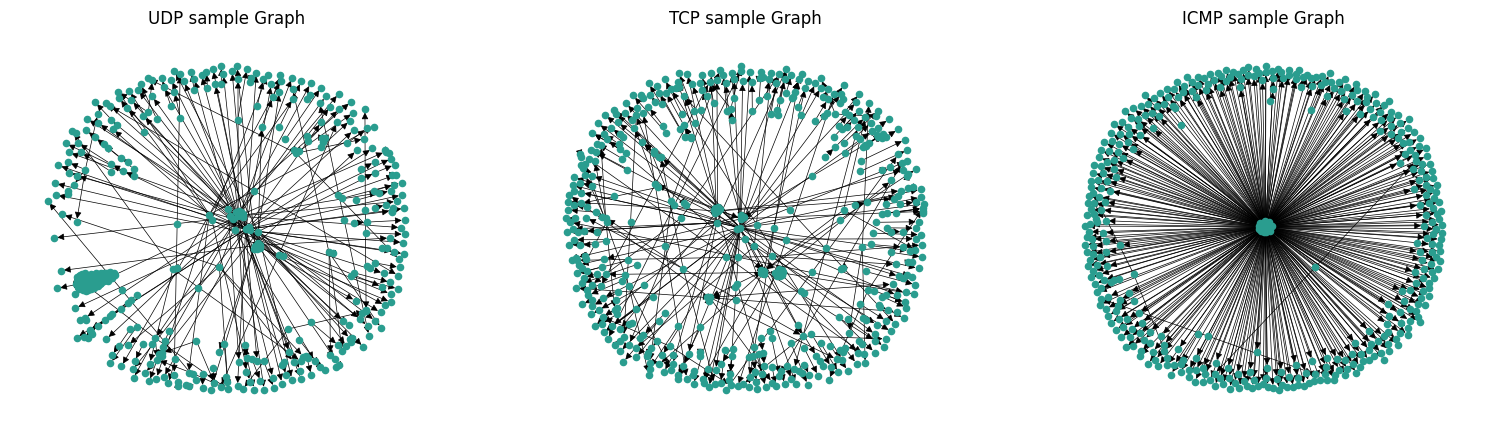

In [62]:
plt.style.use('_mpl-gallery')
fig, axes = plt.subplots(1,3, figsize=(15,4))
nx.draw(Graph_subset_UDP,node_size = 20, width = 0.5, node_color = '#2a9d8f', ax=axes[0])
nx.draw(Graph_subset_TCP,node_size = 20, width = 0.5, node_color = '#2a9d8f', ax=axes[1])
nx.draw(Graph_subset_ICMP,node_size = 20, width = 0.5, node_color = '#2a9d8f', ax=axes[2])

axes[0].set_title("UDP sample Graph")
axes[1].set_title("TCP sample Graph")
axes[2].set_title("ICMP sample Graph")

plt.show()


After this overview of the topology we have decided to put together the TCP and UDP packets since the graphs do seem to be very similar, while the ICMP graph has a particular topology with fewer sources and more destinations than the other two protocols. <br>
This is beacause the ICMP protocol is used for troubleshooting, the sources want to know if the destinations are reacheable.

### Transport GRAPH

Here, as we have just mentioned above we are going to build a single graph containing both the packets send using the TCP or UDP protocols.

In [63]:
# So let's merge them!
data_transport = data_transport.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port',"Protocol"]).first().reset_index()
data_transport = data_transport[['IP_SRC', 'IP_DST', 'src_port', 'dst_port',"Protocol"]]
#data_transport=data_transport.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port',"Protocol"]).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
#data_transport.drop('tot_len',axis=1,inplace=True)
TR=data_transport[['IP_SRC','IP_DST']]
tr_count=dict(TR.value_counts())
l=[]
for i in range(len(data_transport)):
    l.append(tr_count[(data_transport.iloc[i]['IP_SRC'],data_transport.iloc[i]['IP_DST'])])
data_transport['Num Flows']=l
#data_transport

In [64]:
# Creating the new graph for both TCP and UDP
Graph_Transport=nx.DiGraph()
prot={17:'UDP',6:'TCP'}
for _,i in data_transport.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    p=prot[i.Protocol]
    if (node_a,node_b) in Graph_Transport.edges:
        Graph_Transport.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'],p)]
    else:
        Graph_Transport.add_edge(node_a,node_b)
        Graph_Transport.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_Transport.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'],p)]

In [66]:
#Graph_Transport.get_edge_data("95.36.218.85","202.9.24.18")

And now let's observe a small sample of the graph obtained combining both UDP and TCP pkts.

In [67]:
transport_sample = data_transport.sample(400)
#transport_sample

In [68]:
np.unique(transport_sample.Protocol)

array([ 6, 17], dtype=int64)

In [69]:
Graph_Subset_Transport=nx.DiGraph()
prot={17:'UDP',6:'TCP'}
for _,i in transport_sample.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    p=prot[i.Protocol]
    if (node_a,node_b) in Graph_Subset_Transport.edges:
        Graph_Subset_Transport.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'],p)]
    else:
        Graph_Subset_Transport.add_edge(node_a,node_b)
        Graph_Subset_Transport.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_Subset_Transport.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'],p)]

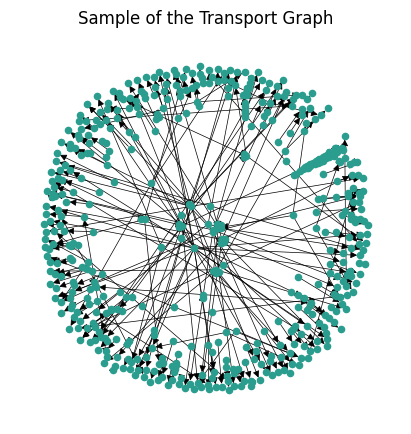

In [70]:
fig,ax=plt.subplots(figsize=(4,4))
nx.draw(Graph_Subset_Transport,node_size = 20, width = 0.5, node_color = '#2a9d8f', font_size = 6,ax=ax)
plt.title("Sample of the Transport Graph")
plt.show()

As we have observed before, the overall topology is very similar to the two graphs that we saw before. Hence, we think that, in terms of the topological study, it makes more sense to study the entirety of the pkt that use TCP and UDP altogether. 

In [78]:
e1,e2=transport_sample[transport_sample['Num Flows']>1].iloc[0][['IP_SRC','IP_DST']]

In [79]:
Graph_Subset_Transport.get_edge_data(e1, e2)
# Here we can observe how now every flow has both assigned the source and the destination port plus the protocol used

{'Num Flow': 2, 'List': [(36420, 443, 'UDP')]}

### Different Metrics to obtain a better understanding of the Graphs' topologies

In [80]:
# How many nodes we have?
print("Number of nodes: %.0f"% nx.number_of_nodes(Graph_ICMP))
print("Number of edges: %.0f"% nx.number_of_edges(Graph_ICMP))


Number of nodes: 10162
Number of edges: 10615


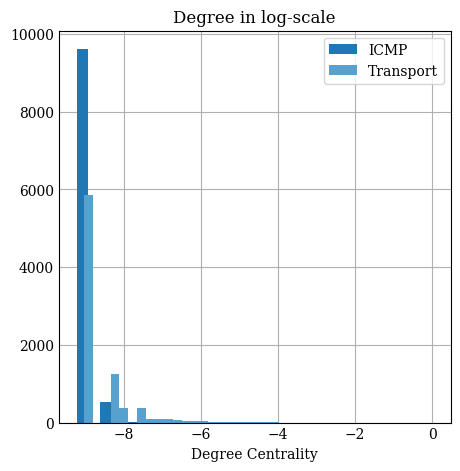

In [83]:
# Degree of the two Graphs
Counter(nx.degree_histogram(Graph_ICMP)) #almost all the nodes have degree 0
#The degree centrality for a node v is the fraction of nodes it is connected to.
plt.style.use('_mpl-gallery')
plt.rcParams['font.family'] = 'Serif'
plt.figure(figsize=(4, 4))
#fig, axes = plt.subplots(1,2, figsize=(15,4))
icmp_hist = plt.hist(np.log(list(nx.degree_centrality(Graph_ICMP).values())),bins=30,label='ICMP')
transport_hist = plt.hist(np.log(list(nx.degree_centrality(Graph_Transport).values())),bins=30,label='Transport')
plt.xlabel("Degree Centrality")
plt.legend()
plt.title("Degree in log-scale")
plt.show()
# there are lot of nodes that are destination and have a degree centrality near 0.
# Nonetheless there are very few nodes with higher degree centrality

In [84]:
print("The mean of the degree of the Transport Graph is %.6f"% np.mean(list(nx.degree_centrality(Graph_Transport).values())),"and the variance is %.6f"% np.var(list(nx.degree_centrality(Graph_Transport).values())))
print("The mean of the degree of the ICMP Graph is %.6f"% np.mean(list(nx.degree_centrality(Graph_ICMP).values())),"and the variance is %.6f"% np.var(list(nx.degree_centrality(Graph_ICMP).values())))
print()
ratio = np.var(list(nx.degree_centrality(Graph_ICMP).values()))/np.var(list(nx.degree_centrality(Graph_Transport).values()))
print("The ratio between the two variances is %.2f"% ratio ) #strange ratio...

The mean of the degree of the Transport Graph is 0.000337 and the variance is 0.000005
The mean of the degree of the ICMP Graph is 0.000206 and the variance is 0.000102

The ratio between the two variances is 21.90


In [85]:
print("How many nodes we need to delete to have a disconnected graph?", apx.node_connectivity(Graph_ICMP)) # The graph is not connected and we can not calculate algorithms like the longest path
# Node connectivity is equal to the minimum number of nodes that must be removed to disconnect G or render it trivial. 
# By Menger’s theorem, this is equal to the number of node independent paths (paths that share no nodes other than source and target).

How many nodes we need to delete to have a disconnected graph? 0


Our graphs are disconnected and directed, in order to evaluate other metrics we construct the undirected versions of the two graphs

In [86]:
# UNDIRECTED GRAPHS
undirected_ICMP = nx.Graph()
undirected_ICMP.add_edges_from(Graph_ICMP.edges())
undirected_transport = nx.Graph()
undirected_transport.add_edges_from(Graph_Transport.edges()) 

In [87]:
print("Is the ICMP graph acyciclic?", nx.is_directed_acyclic_graph(Graph_ICMP)) # so our graph have cycles and we can not do the longest path (also the other 2)
print("Is the Transport graph acyciclic?", nx.is_directed_acyclic_graph(Graph_Transport)) 
print("Are there some clusters in ICMP?", apx.average_clustering(undirected_ICMP)) #no clutsers in ICMP
print("Are there some clusters in Transport graph?", apx.average_clustering(undirected_transport)) #neither for the transport data

Is the ICMP graph acyciclic? False
Is the Transport graph acyciclic? False
Are there some clusters in ICMP? 0.0
Are there some clusters in Transport graph? 0.0


In [88]:
# Let's calculate the number of different components
print("Number of Connected Components of ICMP Graph is", nx.number_connected_components(undirected_ICMP), "and the number of connected components of the Transport Graph is",nx.number_connected_components(undirected_transport))
#ok, now we can look at the set of nodes in the connected graph containing the source that send more (from point 3)
print("The set of nodes in the component of the ICMP Graph cointaing node 150.57.136.251 are", nx.node_connected_component(undirected_ICMP,'150.57.136.251')) #only 4 nodes
print("The cardinality of set of nodes in the component of the Transport Graph cointaing node 150.57.136.251 are", len(nx.node_connected_component(undirected_transport,'150.57.136.251'))) #lot of nodes, let's display how many they are

Number of Connected Components of ICMP Graph is 62 and the number of connected components of the Transport Graph is 533
The set of nodes in the component of the ICMP Graph cointaing node 150.57.136.251 are {'150.57.136.251', '1.1.203.189', '203.39.27.48', '1.1.206.252'}
The cardinality of set of nodes in the component of the Transport Graph cointaing node 150.57.136.251 are 242


In [89]:
# Now we can look at the diameter of the components
# In graph theory, the diameter of a connected component refers to the longest shortest path between any two nodes within that component. 
# In other words, it measures the maximum number of edges that must be traversed to go from one node to another within the component.
component_diameter_ICMP = []
for component in nx.connected_components(undirected_ICMP):
    component_diameter_ICMP.append(nx.diameter(undirected_ICMP.subgraph(component)))

# mmm, takes 1 minutes to run, I don't know if it is usefull

In [90]:
component_diameter_T = []
for component in nx.connected_components(undirected_transport):
    component_diameter_T.append(nx.diameter(undirected_transport.subgraph(component)))
# this takes 2 minutes

In [91]:
#Prepare the Bar Plot for both the ICMP and the Transport Diameters
#ICMP
ICMPx=list(range(min(component_diameter_ICMP),max(component_diameter_ICMP)+1))
aux=dict(sorted(Counter(component_diameter_ICMP).items()))
for i in ICMPx:
    if i not in aux.keys():
        aux[i]=0
ICMPy=list(dict(sorted(aux.items())).values())

#Transport
Tx=list(range(min(component_diameter_T),max(component_diameter_T)+1))
auxT=dict(sorted(Counter(component_diameter_T).items()))
for i in Tx:
    if i not in auxT.keys():
        auxT[i]=0
auxT[0]=0
Tx.append(0)
Tx=sorted(Tx)
Ty=list(dict(sorted(auxT.items())).values())

In [104]:
Tx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

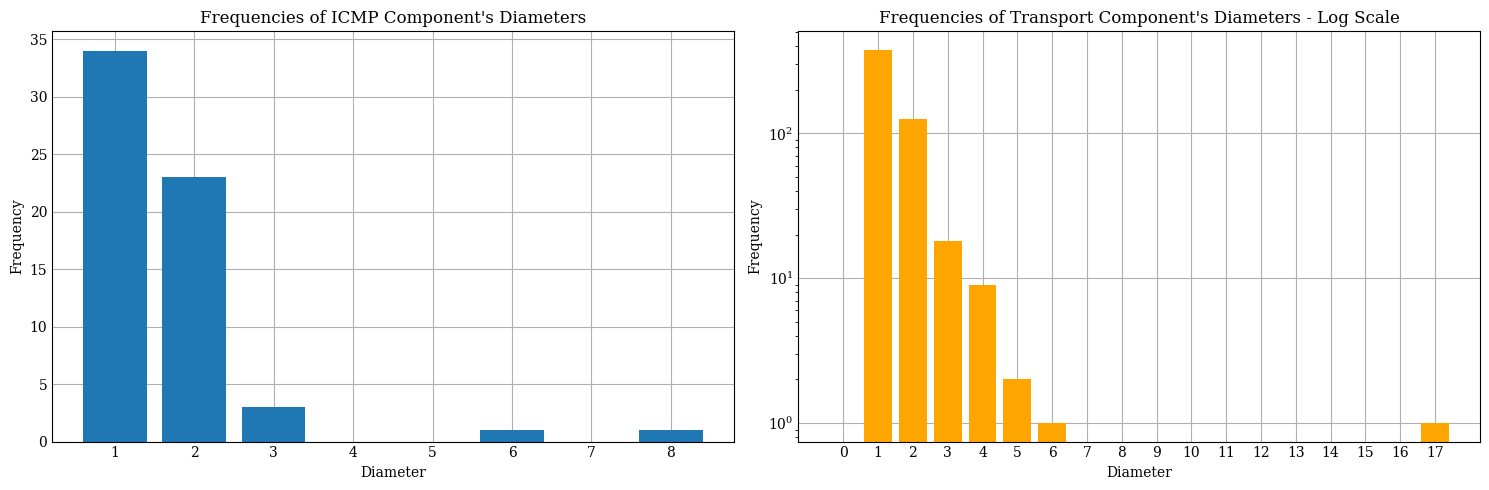

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5),sharey=False)

# Bar Plot ICMP diameter nel primo subplot
ax1.bar(ICMPx, ICMPy, label="ICMP diameter")
ax1.set_xlabel("Diameter")
ax1.set_ylabel("Frequency")
ax1.set_title("Frequencies of ICMP Component's Diameters")

# Bar Plot Transport diameter nel secondo subplot
ax2.bar(Tx,Ty, label="Transport diameter", color='orange')
ax2.set_xlabel("Diameter")
ax2.set_ylabel("Frequency")
ax2.set_title("Frequencies of Transport Component's Diameters - Log Scale")
ax2.set_xticks(range(len(Tx)), Tx)
ax2.set_yscale("log")

plt.tight_layout()
plt.show()

# Part B

In [40]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from kneed import KneeLocator
import math, pickle

In [41]:
dataFrame["Label DSCP"] = pd.to_numeric(dataFrame["Label DSCP"])

ValueError: Unable to parse string "BE" at position 0

In [23]:
dscp_tab = {0: "BE",
            8: "Priority",
            10: "Priority",
            12: "Priority",
            14: "Priority",
            16: "Immediate",
            18: "Immediate",
            20: "Immediate",
            22: "Immediate",
            24: "Flash voice",
            26: "Flash voice",
            28: "Flash voice",
            30: "Flash voice",
            32: "Flash Override",
            34: "Flash Override",
            36: "Flash Override",
            38: "Flash Override",
            40: "Critical voice RTP",
            46: "Critical voice RTP",
            48: "Internetwork control",
            56: "Network Control"
            } 

dataFrame = dataFrame.replace({'Label DSCP': dscp_tab})
dataFrame = dataFrame.replace({'Label DSCP': {"Priority":"AF","Immediate":"AF","Flash voice":"AF",
                                "Flash Override":"AF","Critical voice RTP":"EF",
                                 "Internetwork control":"CS6","Network Control":"CS6",
                                 4:"NotKnown",2:"NotKnown",6:"NotKnown",7:"NotKnown",
                                 1:"NotKnown",41:"EF",42:"EF",43:"EF",44:"EF",45:"EF",49:"NotKnown",54:"NotKnown",11:"NotKnown",50:"NotKnown",29:"NotKnown"}})

print("DSCP Occurrences: ")
print(dict(Counter(dataFrame["Label DSCP"])))

DSCP Occurrences: 
{'BE': 829966, 'NotKnown': 138, 'AF': 1172, 'EF': 1149, 'CS6': 343}


In [15]:
dataFrame

,Label DSCP,header len,ds_field,ds_field_ecn,length,Protocol,flag_df,flag_mf,flag_rb,fragment_offset,ttl,IP_SRC,IP_DST,src_port,dst_port,time
0,0,20,0,0,95,17,1,0,0,0,57,23.53.35.140,131.137.126.25,53,48350,1.554872e+09
1,0,20,0,0,1420,6,1,0,0,0,56,150.57.136.251,221.244.225.179,80,64918,1.554872e+09
2,0,20,0,0,52,6,0,0,0,0,54,180.213.208.201,203.122.136.47,53480,80,1.554872e+09
3,0,20,0,0,52,6,0,0,0,0,54,180.213.208.201,203.122.136.47,53480,80,1.554872e+09
4,0,20,0,0,141,17,0,0,0,0,58,150.57.190.76,155.70.48.196,50821,27023,1.554872e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832763,0,20,0,0,1454,6,1,0,0,0,56,150.57.136.251,222.127.201.52,80,62620,1.554872e+09
832764,0,20,0,0,1500,6,1,0,0,0,60,150.57.136.251,66.132.46.70,873,8878,1.554872e+09
832765,0,20,0,0,1500,6,1,0,0,0,60,150.57.136.251,66.132.46.70,873,8878,1.554872e+09
832766,0,20,0,0,1500,6,1,0,0,0,60,150.57.136.251,66.132.46.70,873,8878,1.554872e+09


In [42]:
data_unique = dataFrame.drop_duplicates(["IP_DST","dst_port"])

#all possible (IP_0,port_0)
flows_list = data_unique[["IP_DST","dst_port"]].values.tolist()


dict_rows = {}

for i in tqdm(range(len(flows_list))):
    #extract all packets received by each specific couple IP dst, port destination
    subdata = dataFrame[(dataFrame["IP_DST"] == flows_list[i][0]) & (dataFrame["dst_port"] == flows_list[i][1])]
    
    #20 is just the length of our vector when we change the values in a logaritmic scale
    #max 2**19 --> 524288 | This consideration depends on your dataset
    length = np.zeros(21)
    pkt = np.zeros(21)
    
    #At least 2 pkts received by this specific (IP_0,port_0)
    if subdata.shape[0] >= 2:
        
        

        #Check about the label, we want to be sure to analyze a couple with just 1 DSCP
        #The vector that represents this element will have just one label
        
        if Counter(subdata["Label DSCP"] == 1):
        
            dtu = subdata.drop_duplicates(["IP_SRC","src_port"])
            
            list_couple_src = dtu[["IP_SRC","src_port"]].values.tolist()
            minimum,maximum=np.infty,0
            for elem in list_couple_src:
                #Observe each element in the Neighborhood (N)
                finaldata = subdata[(subdata["IP_SRC"]==elem[0]) & (subdata["src_port"]==elem[1])]
                aux1,aux2=min(finaldata['length']),max(finaldata['length'])
                if aux1<minimum:
                    minimum=aux1
                if aux2>maximum:
                    maximum=aux2
                #Number of packets
                #Ex: pck = 245, log_{2}(245) = 7.94 --> ceil()--> 8 
                #The range considered is (2**7,2**8] = (128,256]
                length[math.ceil(math.log(finaldata.shape[0])/math.log(2))] += 1
                
                #Packet length analysis --> Byte
                #extract each packet length
                for index,row in finaldata.iterrows():
                    pkt[math.ceil(math.log(row["length"])/math.log(2))] += 1
                    
            #Normalization vector both for packets and bytes    
            dict_rows[(flows_list[i][0],flows_list[i][1])] = [list(Counter(subdata["Label DSCP"]).keys())[0],length/sum(length),pkt/sum(pkt),maximum,minimum]
                
        else:
            #print("problem")
            break

            
#Save the data in a pickle file
aux=pd.DataFrame.from_dict(dict_rows)
pd.to_pickle(aux,'Flows.pkl')

100%|██████████| 20556/20556 [17:58<00:00, 19.05it/s]


In [43]:
dataFlow=pd.read_pickle('Flows.pkl')
dataFlow.T

,,0,1,2,3,4
221.244.225.179,64918,BE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016190661226...",9700,47
203.122.136.47,80,BE,"[0.0, 0.0, 0.16666666666666666, 0.166666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9983525535420...",396,40
155.70.48.196,27023,BE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",192,135
172.201.31.90,443,BE,"[0.25, 0.05, 0.05, 0.15, 0.15, 0.05, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0154854079809...",1420,40
192.226.35.111,443,BE,"[0.02857142857142857, 0.14285714285714285, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8948453608247...",721,40
...,...,...,...,...,...,...
118.101.243.35,60296,BE,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",60,52
150.57.154.156,57659,BE,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",40,40
131.137.220.107,52687,BE,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",52,52
131.137.243.202,55108,BE,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",52,52


In [44]:
#Check the low number of occurrences of the priority flows
dataFlow.iloc[0,:].value_counts()

BE          5688
CS6           33
NotKnown      10
AF             8
EF             5
Name: 0, dtype: int64

In [45]:
data_pandas = []        
for k,val in dataFlow.items():
    obs = []
    obs.append(val[0])
    obs.extend(val[1].tolist())
    obs.extend(val[2].tolist())
    obs.append(val[3])
    obs.append(val[4])
    data_pandas.append(obs)
col = ["Label"]
col.extend(["X"+str(i)for i in range(44)])
dataUns = pd.DataFrame.from_records(data_pandas,columns=col )
#Select just items with a string label and not numeric #mmmm we have all string 
#dataUns = dataUns[dataUns["Label"].isin(['AF','BE', 'CS6','EF','NotKnown'])]
#Useful to encode the label, it will be exploited at the end of the classification
le = preprocessing.LabelEncoder() #here we are transforming "BE" and the other labels into numbers
dataUns["Label"]  = le.fit_transform(dataUns["Label"])

In [50]:
dataUns["Label"].value_counts() 
#so 1 = BE
# 2 = CS6 
# 3 = EF
# 4 = NotKnown
# 0 = AF

1    5688
2      33
4      10
0       8
3       5
Name: Label, dtype: int64

In [47]:
#Extract X,Y
X = dataUns.iloc[:,1:]
Y = dataUns.iloc[:,0]

In [110]:
#Step:
#1)Extract train and test from our starting dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size = 0.30, random_state = 0)

In [111]:
y_test.value_counts()

1    1708
2       8
4       5
3       2
0       1
Name: Label, dtype: int64

In [112]:
#2)Apply oversampling to rebalance in the training the number of occurrences
# Not oversampling the 1, is the BE, we have already loooots of them, make all balanced classes, same cardinality as class with label 1.
oversample = SMOTE(sampling_strategy={0:sum(y_train==1),
                                      2:sum(y_train==1),
                                      4:sum(y_train==1),
                                      3:sum(y_train==1)},k_neighbors=2) 
X_over, Y_over = oversample.fit_resample(x_train, y_train)

print()
print("Starting y_train distribution: ", Counter(y_train))
print("Distribution of the labels before oversampling: ", Counter(le.inverse_transform(y_train)))

print()

print("Distribution of the labels after oversampling: ", Counter(Y_over))
print("Distribution of the labels after oversampling: ", Counter(le.inverse_transform(Y_over)))
print()




Starting y_train distribution:  Counter({1: 3980, 2: 25, 0: 7, 4: 5, 3: 3})
Distribution of the labels before oversampling:  Counter({'BE': 3980, 'CS6': 25, 'AF': 7, 'NotKnown': 5, 'EF': 3})

Distribution of the labels after oversampling:  Counter({1: 3980, 0: 3980, 3: 3980, 2: 3980, 4: 3980})
Distribution of the labels after oversampling:  Counter({'BE': 3980, 'AF': 3980, 'EF': 3980, 'CS6': 3980, 'NotKnown': 3980})



In [113]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 26111998,
    #"n_clusters":10,
}

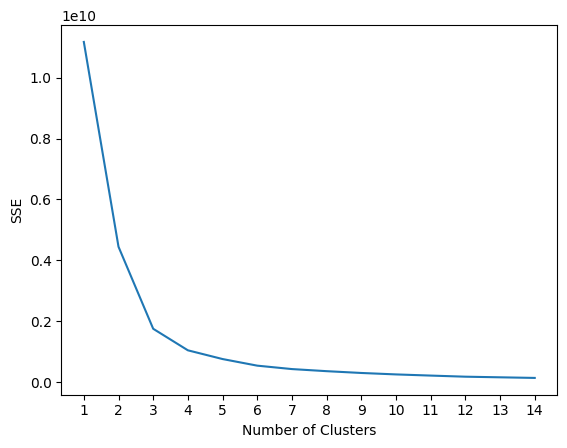

In [114]:
#3)Find the optimal K (number of clusters) according to the training
sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k,**kmeans_kwargs)
    kmeans.fit(X_over)
    sse.append(kmeans.inertia_)

# DA SISTEMARE    
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [115]:
#Extract the minimum in the convex curve 
kl = KneeLocator(
    range(1, 15), sse, curve="convex", direction="decreasing", interp_method= "interp1d"
)
opt = kl.elbow + 2 #TO FIX!!!
print("Optimal number of clusters: ",opt)

Optimal number of clusters:  5


In [116]:
#4) Apply this clustering to the test
#Apply again K.Means with this specific number of clusters
kmeans = KMeans(
    init="k-means++",
    n_clusters=opt,
    n_init=10,
    max_iter=300,
    random_state=26111998
)
kmeans.fit(X_over) #che schifo..

KMeans(n_clusters=5, n_init=10, random_state=26111998)

In [102]:
import operator 

In [117]:
#Observe the results
#In each cluster finding the occurrences of the DSCP Labels

dict_label_dscp = {}

for i in list(set(kmeans.labels_)):
    #print(sum(kmeans.labels_== i))
    ind = []
    for s, j in enumerate(kmeans.labels_):
        if j == i:
            ind.append(s) 

    print("Label: ",i)
    stats = Counter(le.inverse_transform(Y_over[ind]))
    print(stats)
    print(max(stats.items(), key=operator.itemgetter(1))[0])
    dict_label_dscp[i] = max(stats.items(), key=operator.itemgetter(1))[0]
    print()
    print()

Label:  0
Counter({'EF': 3980, 'CS6': 3980, 'NotKnown': 3980, 'AF': 2488, 'BE': 1965})
EF


Label:  1
Counter({'BE': 118})
BE


Label:  2
Counter({'BE': 859, 'AF': 514})
BE


Label:  3
Counter({'BE': 217})
BE


Label:  4
Counter({'AF': 978, 'BE': 821})
AF




In [118]:
#Test
pred = kmeans.predict(x_test)    

prediction = [ dict_label_dscp[elem] for elem in pred ]    

In [119]:
labels = [ "BE", "NotKnown","AF", "EF","CS6"]
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    '''Confusion Matrix Evaluation'''
    
    plt.figure(figsize=(9,9))
    plt.matshow(df_confusion, cmap=cmap,fignum=1) # imshow
    
    for (i, j), z in np.ndenumerate(df_confusion):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                 bbox=dict(boxstyle='round', facecolor='white'))
    
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45,fontsize = 13)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(tick_marks, df_confusion.index,fontsize = 13)
    plt.tight_layout()
    #plt.ylabel(df_confusion.index.name)
    #plt.xlabel(df_confusion.columns.name)
    plt.ylabel("True",fontsize = 18)
    plt.xlabel("Predicted",fontsize = 18)
    plt.grid(False)
    #plt.savefig("")
    plt.show()

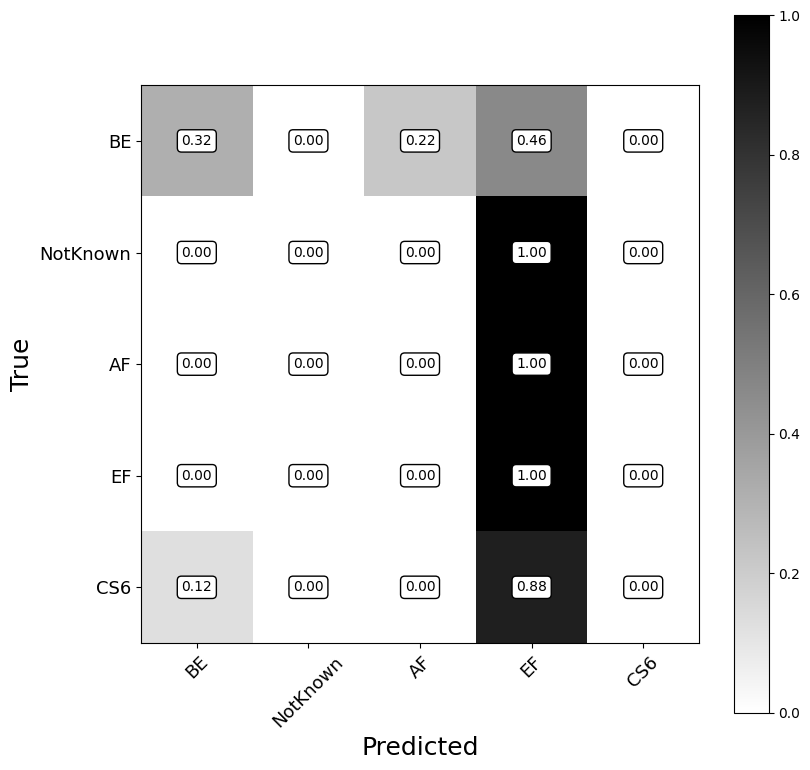

In [120]:
# Confusion matrix evaluation   
confmatrix = confusion_matrix(le.inverse_transform(y_test), 
                              prediction,
                 labels=labels)

df_confusion = pd.DataFrame(confmatrix, index=labels, columns=labels)
df_conf_norm = df_confusion.div(df_confusion.sum(axis=1),axis=0)

plot_confusion_matrix(df_conf_norm)


In [ ]:
# Silhoutte !! 